# Five Layer CNN Training
This notebook trains a five layer CNN on the plant dataset

In [1]:
import time
import os

import numpy as np
import pandas as pd
from plotnine import *
import sklearn.model_selection
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms
import torch.backends.cudnn as cudnn
import tqdm

In [2]:
class FiveLayerCNN(nn.Module):
    '''A simple five layer convolutional neural network consisting of four convolution
    and maxpooling layers, followed by a single fully connected layer.'''
    def __init__(self):
        super(FiveLayerCNN, self).__init__()
        
        self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
        self.conv2 = torch.nn.Conv2d(32, 64, 3)
        self.conv3 = torch.nn.Conv2d(64, 64, 3)
        self.conv4 = torch.nn.Conv2d(64, 32, 3)
        self.fc1 = torch.nn.Linear(in_features=800, out_features=12)
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = nn.MaxPool2d(kernel_size=4, stride=4, padding=0)(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)(x)
        # Flatten image
        x = torch.reshape(x, (-1, 800))
        x = self.fc1(x)
        
        return x

In [3]:
seed = 42

np.random.seed(seed)                                                                       
torch.manual_seed(seed)                                                                    
if torch.backends.cudnn.enabled:                                                                
    torch.backends.cudnn.deterministic = True                                                   
    torch.backends.cudnn.benchmark = False

In [4]:
data_dir = '../data/'

data_transform = transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0, 0, 0], std=[1, 1, 1])
])

image_dataset = datasets.ImageFolder(os.path.join(data_dir, "train"), transform = data_transform)

train_indices, tune_indices = sklearn.model_selection.train_test_split(np.arange(len(image_dataset)), 
                                                                       test_size=.1, random_state=seed)

train_data = torch.utils.data.Subset(image_dataset, train_indices)
tune_data = torch.utils.data.Subset(image_dataset, tune_indices)

train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=16, shuffle=True)
tune_dataloader = torch.utils.data.DataLoader(tune_data)

dataset_size = len(image_dataset)
class_names = image_dataset.classes

device = torch.device("cuda")

model = FiveLayerCNN()

criterion = nn.CrossEntropyLoss()
criterion = criterion.cpu()
optimizer = optim.Adam(model.parameters(), lr=.001)

model.to(device)
overall_step = 0
epochs = 250

best_tune_loss = None
tune_losses = []
train_losses = []
tune_accuracies = []

for epoch in tqdm.tqdm_notebook(range(epochs)):  # loop over the dataset multiple times
    train_loss = 0
    tune_loss = 0
    tune_correct = 0
    for data in tqdm.tqdm_notebook(train_dataloader, total=len(train_dataloader)):
        # get the inputs
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #print(model.state_dict()['fc1.weight'].mean())

        
        train_loss += loss.item()
        
    
    for data in tune_dataloader:
        with torch.no_grad():
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            predicted = torch.argmax(outputs.data, 1)
            
            tune_loss += criterion(outputs, labels).item()
            tune_correct += accuracy_score(predicted.cpu(), labels.cpu(), normalize=False)
    
    
    tune_losses.append(tune_loss)
    train_losses.append(train_loss)

    accuracy = tune_correct / len(tune_data)
    tune_accuracies.append(accuracy)
    
    print('Epoch:\t{}\tTrain Loss:\t{}\tTune Loss:\t{}\tTune Acc:\t{}'.format(epoch, train_loss, 
                                                                              tune_loss, accuracy))
            
    # Save model
    if best_tune_loss is None or tune_loss < best_tune_loss:
        best_tune_loss = tune_loss
        torch.save(model.state_dict(), '../results/trained_5lCNN.pkl')


Epoch:	0	Train Loss:	597.9164988994598	Tune Loss:	809.6432955265045	Tune Acc:	0.4231578947368421



Epoch:	1	Train Loss:	437.0044255256653	Tune Loss:	720.5235530138016	Tune Acc:	0.47368421052631576



Epoch:	2	Train Loss:	404.61176574230194	Tune Loss:	666.0018103122711	Tune Acc:	0.5263157894736842



Epoch:	3	Train Loss:	378.53429996967316	Tune Loss:	651.507003068924	Tune Acc:	0.5452631578947369



Epoch:	4	Train Loss:	326.00100606679916	Tune Loss:	540.6387231349945	Tune Acc:	0.6



Epoch:	5	Train Loss:	269.55734914541245	Tune Loss:	482.9442929029465	Tune Acc:	0.6547368421052632



Epoch:	6	Train Loss:	234.3777433335781	Tune Loss:	419.7620093822479	Tune Acc:	0.6968421052631579



Epoch:	7	Train Loss:	217.47286024689674	Tune Loss:	402.94708693027496	Tune Acc:	0.7052631578947368



Epoch:	8	Train Loss:	198.7094289213419	Tune Loss:	402.92014306783676	Tune Acc:	0.7221052631578947



Epoch:	9	Train Loss:	190.5070275813341	Tune Loss:	372.766955524683	Tune Acc:	0.7263157894736842



Epoch:	10	Train Loss:	179.61447271704674	Tune Loss:	453.79950588941574	Tune Acc:	0.6757894736842105



Epoch:	11	Train Loss:	166.88275155425072	Tune Loss:	412.7510123550892	Tune Acc:	0.7221052631578947



Epoch:	12	Train Loss:	157.99931919574738	Tune Loss:	369.7603780925274	Tune Acc:	0.7642105263157895



Epoch:	13	Train Loss:	150.2140430510044	Tune Loss:	347.62195789813995	Tune Acc:	0.7347368421052631



Epoch:	14	Train Loss:	147.65708853304386	Tune Loss:	373.36904242634773	Tune Acc:	0.7642105263157895



Epoch:	15	Train Loss:	139.8830679729581	Tune Loss:	383.2981467843056	Tune Acc:	0.7452631578947368



Epoch:	16	Train Loss:	131.5962394103408	Tune Loss:	364.09022384881973	Tune Acc:	0.751578947368421



Epoch:	17	Train Loss:	128.55021020025015	Tune Loss:	435.74873822927475	Tune Acc:	0.7242105263157895



Epoch:	18	Train Loss:	123.6664389744401	Tune Loss:	349.6884537637234	Tune Acc:	0.7705263157894737



Epoch:	19	Train Loss:	116.65925086289644	Tune Loss:	345.8534606099129	Tune Acc:	0.7705263157894737



Epoch:	20	Train Loss:	111.08511996269226	Tune Loss:	366.94480852782726	Tune Acc:	0.7768421052631579



Epoch:	21	Train Loss:	108.48585947602987	Tune Loss:	358.1478929296136	Tune Acc:	0.7557894736842106



Epoch:	22	Train Loss:	104.83779031783342	Tune Loss:	356.9023693948984	Tune Acc:	0.7621052631578947



Epoch:	23	Train Loss:	99.82971891760826	Tune Loss:	379.0173162817955	Tune Acc:	0.76



Epoch:	24	Train Loss:	103.5242343917489	Tune Loss:	348.89197409152985	Tune Acc:	0.783157894736842



Epoch:	25	Train Loss:	91.65260288864374	Tune Loss:	389.2705300152302	Tune Acc:	0.7557894736842106



Epoch:	26	Train Loss:	92.64469354599714	Tune Loss:	384.3635019659996	Tune Acc:	0.7789473684210526



Epoch:	27	Train Loss:	86.08017011359334	Tune Loss:	420.20565193891525	Tune Acc:	0.7705263157894737



Epoch:	28	Train Loss:	88.91230475902557	Tune Loss:	363.90212589502335	Tune Acc:	0.7873684210526316



Epoch:	29	Train Loss:	81.95630431035534	Tune Loss:	389.89678460359573	Tune Acc:	0.7936842105263158



Epoch:	30	Train Loss:	76.00824958086014	Tune Loss:	467.09488812088966	Tune Acc:	0.7557894736842106



Epoch:	31	Train Loss:	82.87750454060733	Tune Loss:	392.88891887664795	Tune Acc:	0.7768421052631579



Epoch:	32	Train Loss:	71.42651500552893	Tune Loss:	406.3270789645612	Tune Acc:	0.7978947368421052



Epoch:	33	Train Loss:	67.10218758136034	Tune Loss:	414.9496786110103	Tune Acc:	0.7936842105263158



Epoch:	34	Train Loss:	70.40990269184113	Tune Loss:	422.56700617074966	Tune Acc:	0.7726315789473684



Epoch:	35	Train Loss:	66.25077084079385	Tune Loss:	436.4377232901752	Tune Acc:	0.7894736842105263



Epoch:	36	Train Loss:	70.30448923748918	Tune Loss:	418.51978293061256	Tune Acc:	0.783157894736842



Epoch:	37	Train Loss:	64.45787673071027	Tune Loss:	424.9048852995038	Tune Acc:	0.8



Epoch:	38	Train Loss:	58.88143577706069	Tune Loss:	434.3038586676121	Tune Acc:	0.791578947368421



Epoch:	39	Train Loss:	59.34064641967416	Tune Loss:	490.07036532461643	Tune Acc:	0.7726315789473684



Epoch:	40	Train Loss:	54.487097915261984	Tune Loss:	479.8028603196144	Tune Acc:	0.7873684210526316



Epoch:	41	Train Loss:	58.040603153407574	Tune Loss:	435.5890758931637	Tune Acc:	0.791578947368421



Epoch:	42	Train Loss:	47.46036829147488	Tune Loss:	462.70957753807306	Tune Acc:	0.7852631578947369



Epoch:	43	Train Loss:	51.867950714193285	Tune Loss:	564.628875374794	Tune Acc:	0.7578947368421053



Epoch:	44	Train Loss:	49.78586685098708	Tune Loss:	538.8116959929466	Tune Acc:	0.76



Epoch:	45	Train Loss:	50.09797976783011	Tune Loss:	489.4765799343586	Tune Acc:	0.7705263157894737



Epoch:	46	Train Loss:	44.39444855088368	Tune Loss:	498.59099067747593	Tune Acc:	0.7705263157894737



Epoch:	47	Train Loss:	42.33843557660293	Tune Loss:	467.28381049633026	Tune Acc:	0.7936842105263158



Epoch:	48	Train Loss:	45.34481173660606	Tune Loss:	526.5983733683825	Tune Acc:	0.791578947368421



Epoch:	49	Train Loss:	40.2992069106549	Tune Loss:	550.2683379352093	Tune Acc:	0.7557894736842106



Epoch:	50	Train Loss:	36.683210572227836	Tune Loss:	532.0794868208468	Tune Acc:	0.7894736842105263



Epoch:	51	Train Loss:	39.95135952346027	Tune Loss:	542.6822928786278	Tune Acc:	0.791578947368421



Epoch:	52	Train Loss:	40.60397503245622	Tune Loss:	539.7137502133846	Tune Acc:	0.7768421052631579



Epoch:	53	Train Loss:	36.96970243006945	Tune Loss:	541.8570792675018	Tune Acc:	0.7852631578947369



Epoch:	54	Train Loss:	35.889479234814644	Tune Loss:	543.5948237106204	Tune Acc:	0.7873684210526316



Epoch:	55	Train Loss:	31.314290208742023	Tune Loss:	591.7157628536224	Tune Acc:	0.783157894736842



Epoch:	56	Train Loss:	29.96659309696406	Tune Loss:	609.3071086406708	Tune Acc:	0.7684210526315789



Epoch:	57	Train Loss:	41.42472749017179	Tune Loss:	548.3496371507645	Tune Acc:	0.7810526315789473



Epoch:	58	Train Loss:	29.402293637394905	Tune Loss:	584.8334896564484	Tune Acc:	0.7957894736842105



Epoch:	59	Train Loss:	35.22174498003733	Tune Loss:	577.8738852515817	Tune Acc:	0.7747368421052632



Epoch:	60	Train Loss:	34.60621384065598	Tune Loss:	681.0137275159359	Tune Acc:	0.7642105263157895



Epoch:	61	Train Loss:	24.77676370739937	Tune Loss:	692.2812845781446	Tune Acc:	0.7705263157894737



Epoch:	62	Train Loss:	18.2583132066502	Tune Loss:	642.8127396553755	Tune Acc:	0.7726315789473684



Epoch:	63	Train Loss:	20.637364574708045	Tune Loss:	703.3489597141743	Tune Acc:	0.7705263157894737



Epoch:	64	Train Loss:	35.97385650809156	Tune Loss:	614.2276378571987	Tune Acc:	0.76



Epoch:	65	Train Loss:	23.33712793746963	Tune Loss:	653.8334586173296	Tune Acc:	0.7852631578947369



Epoch:	66	Train Loss:	23.553940581157804	Tune Loss:	704.5261221472174	Tune Acc:	0.7578947368421053



Epoch:	67	Train Loss:	17.622936125379056	Tune Loss:	691.7478084713221	Tune Acc:	0.7494736842105263



Epoch:	68	Train Loss:	19.586488519329578	Tune Loss:	674.5858125388622	Tune Acc:	0.7873684210526316



Epoch:	69	Train Loss:	23.690241223433986	Tune Loss:	771.1885170340538	Tune Acc:	0.7894736842105263



Epoch:	70	Train Loss:	20.263943485741038	Tune Loss:	773.3100021257997	Tune Acc:	0.7684210526315789



Epoch:	71	Train Loss:	33.66678997501731	Tune Loss:	756.664407543838	Tune Acc:	0.7621052631578947



Epoch:	72	Train Loss:	20.629275452636648	Tune Loss:	716.6242807805538	Tune Acc:	0.7684210526315789



Epoch:	73	Train Loss:	7.821892719715834	Tune Loss:	759.6456264108419	Tune Acc:	0.7768421052631579



Epoch:	74	Train Loss:	5.084145325527061	Tune Loss:	803.7002678066492	Tune Acc:	0.7936842105263158



Epoch:	75	Train Loss:	13.035906586155761	Tune Loss:	906.7323998957872	Tune Acc:	0.7684210526315789



Epoch:	76	Train Loss:	33.94142543617636	Tune Loss:	706.2120478004217	Tune Acc:	0.7873684210526316



Epoch:	77	Train Loss:	17.80517921534647	Tune Loss:	835.3857887089252	Tune Acc:	0.7642105263157895



Epoch:	78	Train Loss:	11.671561310300604	Tune Loss:	1007.1075626015663	Tune Acc:	0.751578947368421



Epoch:	79	Train Loss:	28.478913741651922	Tune Loss:	801.0721195191145	Tune Acc:	0.7663157894736842



Epoch:	80	Train Loss:	17.04506588028744	Tune Loss:	904.7076827436686	Tune Acc:	0.7621052631578947



Epoch:	81	Train Loss:	12.948735469020903	Tune Loss:	843.1812701374292	Tune Acc:	0.7663157894736842



Epoch:	82	Train Loss:	13.89947915324592	Tune Loss:	923.7568066865206	Tune Acc:	0.7705263157894737



Epoch:	83	Train Loss:	17.928214649669826	Tune Loss:	816.0051026642323	Tune Acc:	0.7852631578947369



Epoch:	84	Train Loss:	14.14288980870333	Tune Loss:	851.2481150105596	Tune Acc:	0.7663157894736842



Epoch:	85	Train Loss:	8.38388495799154	Tune Loss:	934.3879373669624	Tune Acc:	0.7768421052631579



Epoch:	86	Train Loss:	29.722296708263457	Tune Loss:	814.5301607698202	Tune Acc:	0.7768421052631579



Epoch:	87	Train Loss:	11.741467450745404	Tune Loss:	817.5306098759174	Tune Acc:	0.7810526315789473



Epoch:	88	Train Loss:	3.7881264279130846	Tune Loss:	856.2734916880727	Tune Acc:	0.7852631578947369



Epoch:	89	Train Loss:	1.7116401959983705	Tune Loss:	913.4296938180923	Tune Acc:	0.8



Epoch:	90	Train Loss:	0.7219137789215893	Tune Loss:	927.3637868613005	Tune Acc:	0.8



Epoch:	91	Train Loss:	0.5032800692133605	Tune Loss:	945.4746652841568	Tune Acc:	0.8105263157894737



Epoch:	92	Train Loss:	0.49396063637686893	Tune Loss:	958.2167926281691	Tune Acc:	0.8042105263157895



Epoch:	93	Train Loss:	0.34673065870447317	Tune Loss:	986.3011470735073	Tune Acc:	0.8105263157894737



Epoch:	94	Train Loss:	0.2776357939776517	Tune Loss:	1018.2346147485077	Tune Acc:	0.7957894736842105



Epoch:	95	Train Loss:	0.24386274426797172	Tune Loss:	1017.5099042579532	Tune Acc:	0.8084210526315789



Epoch:	96	Train Loss:	0.21240214604040375	Tune Loss:	1041.8432998284698	Tune Acc:	0.8042105263157895



Epoch:	97	Train Loss:	0.19168821489438415	Tune Loss:	1057.191566646099	Tune Acc:	0.8063157894736842



Epoch:	98	Train Loss:	0.1700806561079844	Tune Loss:	1091.3115332126617	Tune Acc:	0.7978947368421052



Epoch:	99	Train Loss:	87.82934803655371	Tune Loss:	662.2518372386694	Tune Acc:	0.7873684210526316



Epoch:	100	Train Loss:	24.409200524911284	Tune Loss:	809.8894118368626	Tune Acc:	0.7768421052631579



Epoch:	101	Train Loss:	7.678361855330877	Tune Loss:	774.6839875355363	Tune Acc:	0.7873684210526316



Epoch:	102	Train Loss:	2.1626703403890133	Tune Loss:	821.5323831290007	Tune Acc:	0.7873684210526316



Epoch:	103	Train Loss:	1.312440895009786	Tune Loss:	816.9043807983398	Tune Acc:	0.8168421052631579



Epoch:	104	Train Loss:	0.8871312991250306	Tune Loss:	845.5804679095745	Tune Acc:	0.8126315789473684



Epoch:	105	Train Loss:	0.9143899121166612	Tune Loss:	877.7434301376343	Tune Acc:	0.8042105263157895



Epoch:	106	Train Loss:	0.8066272712312639	Tune Loss:	918.6438182368875	Tune Acc:	0.7768421052631579



Epoch:	107	Train Loss:	53.05429599434137	Tune Loss:	770.5409070961177	Tune Acc:	0.7789473684210526



Epoch:	108	Train Loss:	9.352831925731152	Tune Loss:	834.3237252831459	Tune Acc:	0.783157894736842



Epoch:	109	Train Loss:	2.5804926601122133	Tune Loss:	869.9954878389835	Tune Acc:	0.783157894736842



Epoch:	110	Train Loss:	14.932781313236774	Tune Loss:	910.2698741555214	Tune Acc:	0.7621052631578947



Epoch:	111	Train Loss:	22.30756201222539	Tune Loss:	901.1361099183559	Tune Acc:	0.783157894736842



Epoch:	112	Train Loss:	9.101473701186478	Tune Loss:	942.4732593297958	Tune Acc:	0.783157894736842



Epoch:	113	Train Loss:	15.251704356633127	Tune Loss:	904.315316349268	Tune Acc:	0.7642105263157895



Epoch:	114	Train Loss:	5.462280119070783	Tune Loss:	961.65353487432	Tune Acc:	0.7789473684210526



Epoch:	115	Train Loss:	1.1855676693376154	Tune Loss:	952.2603989578784	Tune Acc:	0.791578947368421



Epoch:	116	Train Loss:	0.5302425710833631	Tune Loss:	961.0149539709091	Tune Acc:	0.7810526315789473



Epoch:	117	Train Loss:	0.38088904367759824	Tune Loss:	975.7793117426336	Tune Acc:	0.7873684210526316



Epoch:	118	Train Loss:	0.22835271840449423	Tune Loss:	994.6162183880806	Tune Acc:	0.7873684210526316



Epoch:	119	Train Loss:	0.1932726518716663	Tune Loss:	1009.3284607231617	Tune Acc:	0.7936842105263158



Epoch:	120	Train Loss:	0.16623089369386435	Tune Loss:	1024.8987690806389	Tune Acc:	0.7957894736842105



Epoch:	121	Train Loss:	0.14334015967324376	Tune Loss:	1037.4047928601503	Tune Acc:	0.7936842105263158



Epoch:	122	Train Loss:	0.12599698128178716	Tune Loss:	1046.157036781311	Tune Acc:	0.7978947368421052



Epoch:	123	Train Loss:	0.11113070487044752	Tune Loss:	1067.7095958292484	Tune Acc:	0.7936842105263158



Epoch:	124	Train Loss:	0.12022407284530345	Tune Loss:	1091.2842074334621	Tune Acc:	0.7894736842105263



Epoch:	125	Train Loss:	0.08381109571928391	Tune Loss:	1097.856840595603	Tune Acc:	0.7936842105263158



Epoch:	126	Train Loss:	0.07671843358548358	Tune Loss:	1107.2554779052734	Tune Acc:	0.7978947368421052



Epoch:	127	Train Loss:	0.06550621979113203	Tune Loss:	1110.1558467447758	Tune Acc:	0.7978947368421052



Epoch:	128	Train Loss:	0.05782668184838258	Tune Loss:	1140.508763808757	Tune Acc:	0.7978947368421052



Epoch:	129	Train Loss:	0.05264088651165366	Tune Loss:	1151.5769278928638	Tune Acc:	0.7957894736842105



Epoch:	130	Train Loss:	88.79963751602918	Tune Loss:	718.2224057614803	Tune Acc:	0.7726315789473684



Epoch:	131	Train Loss:	20.125845555681735	Tune Loss:	816.3013789653778	Tune Acc:	0.7621052631578947



Epoch:	132	Train Loss:	8.986396877095103	Tune Loss:	838.7495313584805	Tune Acc:	0.7768421052631579



Epoch:	133	Train Loss:	12.840016863541678	Tune Loss:	779.6051409319043	Tune Acc:	0.7894736842105263



Epoch:	134	Train Loss:	1.951716999639757	Tune Loss:	870.6458950638771	Tune Acc:	0.7852631578947369



Epoch:	135	Train Loss:	0.5442461000250205	Tune Loss:	874.8115263357759	Tune Acc:	0.7873684210526316



Epoch:	136	Train Loss:	0.35397592032677494	Tune Loss:	912.8527389168739	Tune Acc:	0.7957894736842105



Epoch:	137	Train Loss:	0.27141842152923346	Tune Loss:	919.5018965154886	Tune Acc:	0.7894736842105263



Epoch:	138	Train Loss:	0.22528591973241419	Tune Loss:	930.9731206893921	Tune Acc:	0.7894736842105263



Epoch:	139	Train Loss:	0.18641880356153706	Tune Loss:	954.1439858078957	Tune Acc:	0.783157894736842



Epoch:	140	Train Loss:	0.16853629349498078	Tune Loss:	962.4221094846725	Tune Acc:	0.783157894736842



Epoch:	141	Train Loss:	0.13697492631035857	Tune Loss:	980.382655069232	Tune Acc:	0.7873684210526316



Epoch:	142	Train Loss:	0.1217225196887739	Tune Loss:	989.8448504656553	Tune Acc:	0.7852631578947369



Epoch:	143	Train Loss:	0.10517849517054856	Tune Loss:	1011.2486108802259	Tune Acc:	0.7852631578947369



Epoch:	144	Train Loss:	0.09165983767434227	Tune Loss:	1027.1357825100422	Tune Acc:	0.7873684210526316



Epoch:	145	Train Loss:	0.07885710161644965	Tune Loss:	1038.837903024163	Tune Acc:	0.7873684210526316



Epoch:	146	Train Loss:	0.0694979167310521	Tune Loss:	1057.4018695056438	Tune Acc:	0.791578947368421



Epoch:	147	Train Loss:	0.061358869599644095	Tune Loss:	1075.6290344446898	Tune Acc:	0.7936842105263158



Epoch:	148	Train Loss:	0.054410293931141496	Tune Loss:	1080.355180054903	Tune Acc:	0.791578947368421



Epoch:	149	Train Loss:	0.04961965881375363	Tune Loss:	1109.7243320643902	Tune Acc:	0.7936842105263158



Epoch:	150	Train Loss:	0.04037822084501386	Tune Loss:	1118.9385487399995	Tune Acc:	0.7894736842105263



Epoch:	151	Train Loss:	0.03620375204877746	Tune Loss:	1133.2198418974876	Tune Acc:	0.7957894736842105



Epoch:	152	Train Loss:	0.031907677242998034	Tune Loss:	1155.3207660764456	Tune Acc:	0.791578947368421



Epoch:	153	Train Loss:	0.026805415439412172	Tune Loss:	1157.7789902687073	Tune Acc:	0.791578947368421



Epoch:	154	Train Loss:	0.023639440347324125	Tune Loss:	1181.0347926020622	Tune Acc:	0.8



Epoch:	155	Train Loss:	72.93707993626595	Tune Loss:	830.7124710679054	Tune Acc:	0.7726315789473684



Epoch:	156	Train Loss:	25.714320870116353	Tune Loss:	881.2952914535999	Tune Acc:	0.7747368421052632



Epoch:	157	Train Loss:	6.9432049873284996	Tune Loss:	888.835385014303	Tune Acc:	0.7621052631578947



Epoch:	158	Train Loss:	1.2055252402205952	Tune Loss:	879.8569034300745	Tune Acc:	0.7894736842105263



Epoch:	159	Train Loss:	0.45550065679708496	Tune Loss:	905.8064585104585	Tune Acc:	0.783157894736842



Epoch:	160	Train Loss:	0.3281245903344825	Tune Loss:	924.1839059144258	Tune Acc:	0.7852631578947369



Epoch:	161	Train Loss:	0.26008183014346287	Tune Loss:	938.2168601304293	Tune Acc:	0.7873684210526316



Epoch:	162	Train Loss:	0.20947299358280702	Tune Loss:	959.2397857904434	Tune Acc:	0.791578947368421



Epoch:	163	Train Loss:	0.1749822780257091	Tune Loss:	970.2342249751091	Tune Acc:	0.791578947368421



Epoch:	164	Train Loss:	0.147388560581021	Tune Loss:	985.3482120335102	Tune Acc:	0.7873684210526316



Epoch:	165	Train Loss:	0.13514577024034224	Tune Loss:	1001.6731727719307	Tune Acc:	0.783157894736842



Epoch:	166	Train Loss:	0.11075763788539916	Tune Loss:	1008.3786910772324	Tune Acc:	0.7873684210526316



Epoch:	167	Train Loss:	0.09716183199407169	Tune Loss:	1022.9163008928299	Tune Acc:	0.7873684210526316



Epoch:	168	Train Loss:	0.08509815385332331	Tune Loss:	1036.788832001388	Tune Acc:	0.791578947368421



Epoch:	169	Train Loss:	0.0739852978149429	Tune Loss:	1051.733682513237	Tune Acc:	0.7936842105263158



Epoch:	170	Train Loss:	0.06383342974982043	Tune Loss:	1059.7012623511255	Tune Acc:	0.7894736842105263



Epoch:	171	Train Loss:	0.055059581995010376	Tune Loss:	1080.0999761223793	Tune Acc:	0.7873684210526316



Epoch:	172	Train Loss:	0.048770792469440494	Tune Loss:	1084.8538058977574	Tune Acc:	0.791578947368421



Epoch:	173	Train Loss:	0.04312152386410162	Tune Loss:	1106.322848379612	Tune Acc:	0.791578947368421



Epoch:	174	Train Loss:	0.03771230698475847	Tune Loss:	1108.9813168048859	Tune Acc:	0.791578947368421



Epoch:	175	Train Loss:	0.03206405982928118	Tune Loss:	1131.33488124609	Tune Acc:	0.791578947368421



Epoch:	176	Train Loss:	0.029288725592778064	Tune Loss:	1140.7724981233478	Tune Acc:	0.7978947368421052



Epoch:	177	Train Loss:	0.025338339757581707	Tune Loss:	1162.9416077136993	Tune Acc:	0.7978947368421052



Epoch:	178	Train Loss:	0.0211745179076388	Tune Loss:	1169.1171555817127	Tune Acc:	0.7978947368421052



Epoch:	179	Train Loss:	0.018647686229087412	Tune Loss:	1186.966950893402	Tune Acc:	0.7936842105263158



Epoch:	180	Train Loss:	72.79230092403304	Tune Loss:	916.6057675033808	Tune Acc:	0.7789473684210526



Epoch:	181	Train Loss:	21.725781220011413	Tune Loss:	852.3097603917122	Tune Acc:	0.7621052631578947



Epoch:	182	Train Loss:	4.6064816527068615	Tune Loss:	902.6493264734745	Tune Acc:	0.791578947368421



Epoch:	183	Train Loss:	0.941135877124907	Tune Loss:	930.4221343398094	Tune Acc:	0.7852631578947369



Epoch:	184	Train Loss:	0.35883797629503533	Tune Loss:	955.7721057236195	Tune Acc:	0.7873684210526316



Epoch:	185	Train Loss:	0.2144629004469607	Tune Loss:	982.8918565995991	Tune Acc:	0.791578947368421



Epoch:	186	Train Loss:	0.17121750122169033	Tune Loss:	989.0488616973162	Tune Acc:	0.7873684210526316



Epoch:	187	Train Loss:	0.14350140847636794	Tune Loss:	1008.3009643107653	Tune Acc:	0.7873684210526316



Epoch:	188	Train Loss:	0.12096673727501184	Tune Loss:	1020.2609434425831	Tune Acc:	0.7873684210526316



Epoch:	189	Train Loss:	0.10196370814810507	Tune Loss:	1037.4013699814677	Tune Acc:	0.783157894736842



Epoch:	190	Train Loss:	0.08897745774208943	Tune Loss:	1049.2851128131151	Tune Acc:	0.783157894736842



Epoch:	191	Train Loss:	0.08021422461996508	Tune Loss:	1062.0873250812292	Tune Acc:	0.783157894736842



Epoch:	192	Train Loss:	0.0691016498215049	Tune Loss:	1073.561946685426	Tune Acc:	0.791578947368421



Epoch:	193	Train Loss:	0.06139819372401689	Tune Loss:	1086.8810519110411	Tune Acc:	0.791578947368421



Epoch:	194	Train Loss:	0.055362727551255375	Tune Loss:	1089.7524431347847	Tune Acc:	0.7936842105263158



Epoch:	195	Train Loss:	0.048268391599776805	Tune Loss:	1102.6034209690988	Tune Acc:	0.7936842105263158



Epoch:	196	Train Loss:	0.04375101171899587	Tune Loss:	1121.9416249394417	Tune Acc:	0.7894736842105263



Epoch:	197	Train Loss:	0.03745057552441722	Tune Loss:	1132.1203617304564	Tune Acc:	0.7936842105263158



Epoch:	198	Train Loss:	0.032940582488663495	Tune Loss:	1155.4985649185255	Tune Acc:	0.7873684210526316



Epoch:	199	Train Loss:	0.030451520258793607	Tune Loss:	1183.0627218876034	Tune Acc:	0.7894736842105263



Epoch:	200	Train Loss:	0.03175538539653644	Tune Loss:	1164.1940892785788	Tune Acc:	0.791578947368421



Epoch:	201	Train Loss:	0.023000580571533646	Tune Loss:	1179.0746396780014	Tune Acc:	0.791578947368421



Epoch:	202	Train Loss:	0.020732199152234898	Tune Loss:	1198.4812031760812	Tune Acc:	0.7894736842105263



Epoch:	203	Train Loss:	0.017231822363100946	Tune Loss:	1206.8648030087352	Tune Acc:	0.791578947368421



Epoch:	204	Train Loss:	0.01527776918374002	Tune Loss:	1227.144363604486	Tune Acc:	0.791578947368421



Epoch:	205	Train Loss:	0.013281957944855094	Tune Loss:	1244.0779902227223	Tune Acc:	0.7894736842105263



Epoch:	206	Train Loss:	0.011790280037530465	Tune Loss:	1236.1750508844852	Tune Acc:	0.7936842105263158



Epoch:	207	Train Loss:	0.01087675119197229	Tune Loss:	1266.6854495101143	Tune Acc:	0.791578947368421



Epoch:	208	Train Loss:	0.00960485807945588	Tune Loss:	1288.0445173084736	Tune Acc:	0.791578947368421



Epoch:	209	Train Loss:	0.007834598266526882	Tune Loss:	1282.6384852966294	Tune Acc:	0.7894736842105263



Epoch:	210	Train Loss:	0.0071040260954760015	Tune Loss:	1313.746297903359	Tune Acc:	0.7873684210526316



Epoch:	211	Train Loss:	0.006262644155299313	Tune Loss:	1332.3715515732765	Tune Acc:	0.7894736842105263



Epoch:	212	Train Loss:	0.00534494865405577	Tune Loss:	1334.7270674966276	Tune Acc:	0.7894736842105263



Epoch:	213	Train Loss:	0.004645766690373421	Tune Loss:	1349.4176660329103	Tune Acc:	0.7894736842105263



Epoch:	214	Train Loss:	80.21567425283138	Tune Loss:	925.644934438169	Tune Acc:	0.7557894736842106



Epoch:	215	Train Loss:	15.800888366211439	Tune Loss:	929.6898267194629	Tune Acc:	0.7621052631578947



Epoch:	216	Train Loss:	7.682362528750673	Tune Loss:	1013.9087418094277	Tune Acc:	0.7747368421052632



Epoch:	217	Train Loss:	1.6842815945078655	Tune Loss:	993.4209389835596	Tune Acc:	0.7578947368421053



Epoch:	218	Train Loss:	2.733287569368258	Tune Loss:	1065.4822909012437	Tune Acc:	0.7663157894736842



Epoch:	219	Train Loss:	18.59436649813631	Tune Loss:	1069.585858732462	Tune Acc:	0.7578947368421053



Epoch:	220	Train Loss:	9.592125880837557	Tune Loss:	1087.35557089746	Tune Acc:	0.7705263157894737



Epoch:	221	Train Loss:	4.545016448479146	Tune Loss:	1118.918934598565	Tune Acc:	0.7642105263157895



Epoch:	222	Train Loss:	0.8604707219274133	Tune Loss:	1074.3216108977795	Tune Acc:	0.7642105263157895



Epoch:	223	Train Loss:	0.1611231974875409	Tune Loss:	1089.2534289211035	Tune Acc:	0.7705263157894737



Epoch:	224	Train Loss:	0.11237624404020607	Tune Loss:	1106.8743333518505	Tune Acc:	0.7789473684210526



Epoch:	225	Train Loss:	0.09291538107208908	Tune Loss:	1112.5645238161087	Tune Acc:	0.7789473684210526



Epoch:	226	Train Loss:	0.08036008750787005	Tune Loss:	1130.9825613200665	Tune Acc:	0.7768421052631579



Epoch:	227	Train Loss:	0.06934100847388436	Tune Loss:	1135.2797265350819	Tune Acc:	0.7789473684210526



Epoch:	228	Train Loss:	0.06087186775403097	Tune Loss:	1154.6690318882465	Tune Acc:	0.7810526315789473



Epoch:	229	Train Loss:	0.05494716129032895	Tune Loss:	1160.8264142870903	Tune Acc:	0.7810526315789473



Epoch:	230	Train Loss:	0.05039228391251527	Tune Loss:	1172.1285415291786	Tune Acc:	0.7810526315789473



Epoch:	231	Train Loss:	0.04387346841394901	Tune Loss:	1179.8717892169952	Tune Acc:	0.7789473684210526



Epoch:	232	Train Loss:	0.03870962531073019	Tune Loss:	1188.1841258108616	Tune Acc:	0.7852631578947369



Epoch:	233	Train Loss:	0.03354736704568495	Tune Loss:	1199.7018626630306	Tune Acc:	0.7852631578947369



Epoch:	234	Train Loss:	0.030306704808026552	Tune Loss:	1210.185187498806	Tune Acc:	0.7894736842105263



Epoch:	235	Train Loss:	0.026946742165222304	Tune Loss:	1220.2977947033942	Tune Acc:	0.791578947368421



Epoch:	236	Train Loss:	0.023812531493604183	Tune Loss:	1226.6767461448908	Tune Acc:	0.7936842105263158



Epoch:	237	Train Loss:	0.02136906977102626	Tune Loss:	1246.0817926600575	Tune Acc:	0.7936842105263158



Epoch:	238	Train Loss:	0.01890480190445487	Tune Loss:	1254.8099587075412	Tune Acc:	0.7978947368421052



Epoch:	239	Train Loss:	0.01679991821947624	Tune Loss:	1267.87838229537	Tune Acc:	0.791578947368421



Epoch:	240	Train Loss:	0.014841957989119692	Tune Loss:	1276.1868617124856	Tune Acc:	0.7936842105263158



Epoch:	241	Train Loss:	0.013212340262953148	Tune Loss:	1299.6260235011578	Tune Acc:	0.791578947368421



Epoch:	242	Train Loss:	0.011807775047302016	Tune Loss:	1307.919128317386	Tune Acc:	0.7873684210526316



Epoch:	243	Train Loss:	0.010390251718490617	Tune Loss:	1323.0260325297713	Tune Acc:	0.7873684210526316



Epoch:	244	Train Loss:	0.009264086838811636	Tune Loss:	1328.019868656993	Tune Acc:	0.791578947368421



Epoch:	245	Train Loss:	0.00810475212347228	Tune Loss:	1345.829400986433	Tune Acc:	0.7852631578947369



Epoch:	246	Train Loss:	0.007301427482161671	Tune Loss:	1358.84625576064	Tune Acc:	0.7957894736842105



Epoch:	247	Train Loss:	0.0064278829377144575	Tune Loss:	1365.7380116283894	Tune Acc:	0.7894736842105263



Epoch:	248	Train Loss:	0.005723875074181706	Tune Loss:	1383.8481832444668	Tune Acc:	0.7894736842105263



Epoch:	249	Train Loss:	0.00510584508690215	Tune Loss:	1403.3459582552314	Tune Acc:	0.791578947368421



In [5]:
metrics = {'epochs': list(range(epochs)), 'tune_losses': tune_losses, 'train_losses': train_losses,
          'tune_accuracies': tune_accuracies}
metric_df = pd.DataFrame.from_dict(metrics)

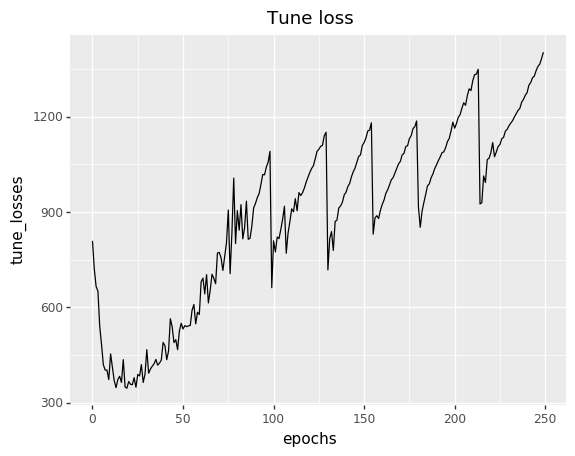

<ggplot: (8793573625201)>

In [6]:
ggplot(metric_df, aes(x = 'epochs', y = 'tune_losses')) + geom_line() + ggtitle('Tune loss')

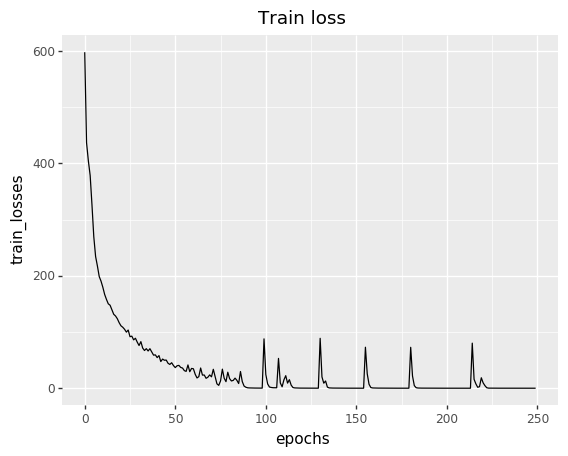

<ggplot: (8793559699285)>

In [7]:
ggplot(metric_df, aes(x = 'epochs', y = 'train_losses')) + geom_line() + ggtitle('Train loss')

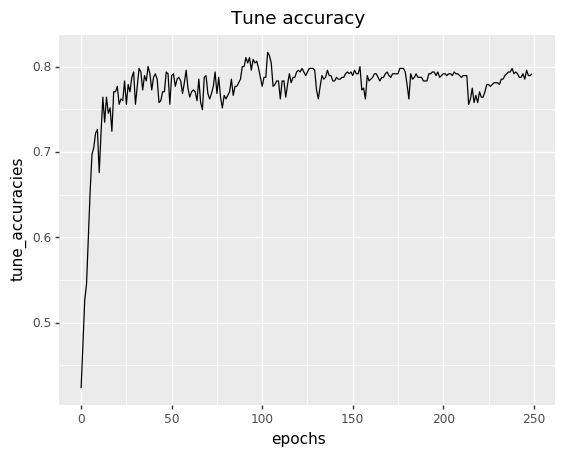

<ggplot: (8793559687357)>

In [8]:
ggplot(metric_df, aes(x = 'epochs', y = 'tune_accuracies')) + geom_line() + ggtitle('Tune accuracy')

Now, we provide the code to evaluate TUEBMnet.

In [26]:
from torchvision.datasets import ImageFolder
from torchvision import transforms, models
from torch.utils import data
import torch
import numpy as np
import sklearn
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
import pandas as pd
import matplotlib.pyplot as plt
from os import listdir
from skimage.io import imread
from numpy.random import poisson, normal, beta, choice
import time
from copy import deepcopy, copy
from PIL import Image
import bagnets.pytorchnet

from dataset import patchnoiser, uniformnoiser, patchswap, tgenerator

In [32]:
seed = 42

np.random.seed(seed)                                                                       
torch.manual_seed(seed) 

img_transform = transforms.Compose([transforms.Resize(255),
                                    transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0, 0, 0], std=[1, 1, 1])]
                                   )
dataset = ImageFolder(root=os.path.join(data_dir, "test"), transform=img_transform)

['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']


In [35]:
train_path = "../results/trained_5lCNN.pkl"

class FiveLayerCNN(nn.Module):
    '''A simple five layer convolutional neural network consisting of four convolution
    and maxpooling layers, followed by a single fully connected layer.'''
    def __init__(self):
        super(FiveLayerCNN, self).__init__()
        self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
        self.conv2 = torch.nn.Conv2d(32, 64, 3)
        self.conv3 = torch.nn.Conv2d(64, 64, 3)
        self.conv4 = torch.nn.Conv2d(64, 32, 3)
        self.fc1 = torch.nn.Linear(in_features=800, out_features=12)
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = nn.MaxPool2d(kernel_size=4, stride=4, padding=0)(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)(x)
        # Flatten image
        x = torch.reshape(x, (-1, 800))
        x = self.fc1(x)
        return x

model = FiveLayerCNN()

model.load_state_dict(torch.load(PATH, map_location=torch.device('cpu')))
model.eval() 

FiveLayerCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=12, bias=True)
)

In [36]:
index = list(range(794))
columns=['file','species']
df_ = pd.DataFrame(index = index, columns=columns)
df_ = df_.fillna(0)

In [37]:
link = os.path.join(data_dir, "test")
testset = tgenerator(link)
testset.viewmode()

Evaluate on clean test set.

Kaggle F1 Score: 0.79471

In [38]:
for i in range(794):
    im = testset[i]
    im = im.view(1,3,224,224)
    
    ytest = torch.max(model(im),1)[1][0].detach()
    
    if(i % 100 ==0):
        print(i)
    
    df_['file'][i] = testset.list_IDs[i]
    df_['species'][i] = dataset.classes[int(ytest)]
    
df_.to_csv(path_or_buf = "../results/predictions_simplenet.csv", index = False)

0


/Users/jlakkis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


100
200
300
400
500
600
700


Evaluate on uniform noise perturbed test set.

Kaggle F1 Score: 0.22732

In [39]:
testset.setmode_uniformnoise(theta=0.6)

for i in range(794):
    im = testset[i]
    im = im.view(1,3,224,224)
    
    ytest = torch.max(model(im.float()),1)[1][0].detach()
    
    if(i % 100 ==0):
        print(i)
    
    df_['file'][i] = testset.list_IDs[i]
    df_['species'][i] = dataset.classes[int(ytest)]
    
df_.to_csv(path_or_buf = "../results/predictions_unformnoise_simplenet.csv", index = False)

0
100
200
300
400
500
600
700


Evaluate on noisy patch perturbed test set.

Kaggle F1 Score: 0.18765

In [40]:
testset.setmode_noisypatch(theta=0.1,p=30,n=40)

for i in range(794):
    im = testset[i]
    im = im.view(1,3,224,224)
    
    ytest = torch.max(model(im.float()),1)[1][0].detach()
    
    if(i % 100 ==0):
        print(i)
    
    df_['file'][i] = testset.list_IDs[i]
    df_['species'][i] = dataset.classes[int(ytest)]
    
df_.to_csv(path_or_buf = "../results/predictions_noisypatch_simplenet.csv", index = False)

0
100
200
300
400
500
600
700


Evaluate on patchswap perturbed test set.

Kaggle F1 Score: 0.51259

In [41]:
testset.setmode_patchswap(p=20, n=50)

for i in range(794):
    im = testset[i]
    im = im.view(1,3,224,224)
    
    ytest = torch.max(model(im.float()),1)[1][0].detach()
    
    if(i % 100 ==0):
        print(i)
    
    df_['file'][i] = testset.list_IDs[i]
    df_['species'][i] = dataset.classes[int(ytest)]
    
df_.to_csv(path_or_buf = "../results/predictions_patchswap_simplenet.csv", index = False)

0
100
200
300
400
500
600
700


Evaluate on texturized test set.

Kaggle F1 Score: 0.24685

In [42]:
link = os.path.join(data_dir, "texturized")
testset = tgenerator(link)
testset.viewmode()

for i in range(794):
    im = testset[i]
    im = im.view(1,3,224,224)
    
    ytest = torch.max(model(im.float()),1)[1][0].detach()
    
    if(i % 100 ==0):
        print(i)
    
    df_['file'][i] = testset.list_IDs[i]
    df_['species'][i] = dataset.classes[int(ytest)]
    
df_.to_csv(path_or_buf = "../results/predictions_texturized_simplenet.csv", index = False)

0
100
200
300
400
500
600
700
